In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Start building the base model

Split the data for training and validation

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
# Load the memory-mapped array
memmap_file = np.memmap("/content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/images.npy", dtype='float32', mode='r', shape=(48126, 224, 224, 3))

print(memmap_file.shape)

(48126, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

images = np.array(memmap_file)
images = preprocess_input(images)

In [ ]:
final_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/final_dataset.csv")

labels = final_dataset['severity']

In [ ]:
final_dataset['severity'].value_counts()

,count
severity,
Normal/Mild,37231
Moderate,7864
Severe,3031


In [ ]:
from tensorflow.keras.utils import to_categorical

classes = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}

labels = labels.map(classes)

labels = to_categorical(labels, num_classes=3)

In [ ]:
labels_to_check = np.argmax(labels, axis=1)
values, counts = np.unique(labels_to_check, return_counts=True)
print(values)
print(counts)

[0 1 2]
[37231  7864  3031]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=final_dataset['severity'])

In [ ]:
labels_ytrain = np.argmax(y_train, axis=1)
values, counts = np.unique(labels_ytrain, return_counts=True)
print(values)
print(counts)

[0 1 2]
[29784  6291  2425]


In [ ]:
labels_yval = np.argmax(y_val, axis=1)
values, counts = np.unique(labels_yval, return_counts=True)
print(values)
print(counts)

[0 1 2]
[7447 1573  606]


In [ ]:
import gc

del memmap_file
del images
del labels
del final_dataset
gc.collect()

102

In [ ]:
#Create temp storage path
temp_storage_path = '/content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/training_temp/'

#Create the directory if it doesn't exist
os.makedirs(temp_storage_path, exist_ok=True)

In [ ]:
import tensorflow as tf

#Define Focal Loss function to handle class imbalance
@tf.keras.utils.register_keras_serializable()
def focal_loss(gamma=2., alpha=[0.2, 0.5, 0.7]):
  @tf.keras.utils.register_keras_serializable()
  def focal_loss_fixed(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    cross_entropy = -y_true * tf.math.log(y_pred)
    loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
    return tf.reduce_mean(loss, axis=-1)
  return focal_loss_fixed

In [ ]:
from sklearn.utils import class_weight

#Compute class weights
y_train_classes = np.argmax(y_train, axis=1)
class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

#Convert the NumPy array to a dictionary
class_weights = dict(enumerate(class_weights_array))


#For Focal Loss
total_examples = 37231 + 7864 + 3031
num_classes = 3

alpha = [
    total_examples / (num_classes * 37231),  # Class 0
    total_examples / (num_classes * 7864),   # Class 1
    total_examples / (num_classes * 3031)    # Class 2
]


In [ ]:
import tensorflow as tf

#Load the base ResNet50 model with pre-trained ImageNet weights, excluding the top layer
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the layers of the base model
base_model.trainable = False

#Add custom layers for fine-tuning
x = base_model.output  # Output of ResNet50 model
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector per image
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Dense layer with ReLU activation , kernel_regularizer=tf.keras.regularizers.l2(0.01)
x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization
x = tf.keras.layers.Dropout(0.3)(x)  # Dropout for 3rd dense layer
output = tf.keras.layers.Dense(3, activation='softmax')(x)  # Final output layer with 3 classes

#Create the full model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Data augmentation and loading using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

#Prepare the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
#Save the model after every epoch in the temp storage file
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    temp_storage_path + 'model_checkpoint_adam_12-22-2024_original.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#Reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

#Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
#Fine tune the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch= len(X_train) // batch_size,
    epochs=20,
    validation_steps= len(X_val) // batch_size,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3173 - loss: 6.5012
Epoch 1: val_loss improved from inf to 1.85099, saving model to /content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/training_temp/model_checkpoint_adam_12-22-2024_original.keras
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 396s 314ms/step - accuracy: 0.3173 - loss: 6.4990 - val_accuracy: 0.5141 - val_loss: 1.8510 - learning_rate: 1.0000e-04
Epoch 2/20
   1/1203 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3750 - loss: 2.1529

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.85099 to 1.31116, saving model to /content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/training_temp/model_checkpoint_adam_12-22-2024_original.keras
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3750 - loss: 2.1529 - val_accuracy: 0.9231 - val_loss: 1.3112 - learning_rate: 1.0000e-04
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3242 - loss: 1.8923
Epoch 3: val_loss improved from 1.31116 to 1.17495, saving model to /content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/training_temp/model_checkpoint_adam_12-22-2024_original.keras
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 372s 307ms/step - accuracy: 0.3242 - loss: 1.8923 - val_accuracy: 0.7734 - val_loss: 1.1750 - learning_rate: 1.0000e-04
Epoch 4/20
   1/1203 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.2812 - loss: 1.5500
Epoch 4: val_loss improved from 1.17495 to 1.09120, saving model to /content/drive/MyDrive/Co

In [ ]:
model.save('/content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/freeze_resnet50_mri_model_Adam_12-22-2024_Original.keras')

In [ ]:
# Evaluate the model
score = model.evaluate(X_val, y_val)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.1457 - loss: 3.1229
Test loss: 3.117953300476074
Test accuracy: 0.14564721286296844


301/301 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step


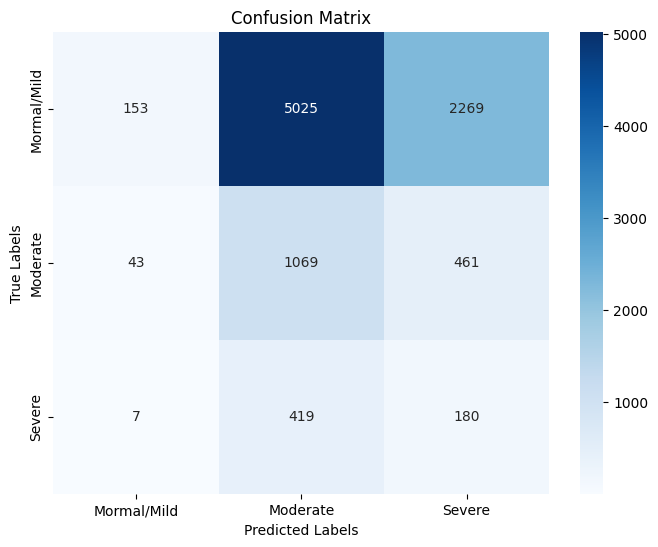

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Mormal/Mild", "Moderate", "Severe"],
            yticklabels=["Mormal/Mild", "Moderate", "Severe"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Unfreeze the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

#Recompile the model with lower lr
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Save the model after every epoch in the temp storage file
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    temp_storage_path + 'model_checkpoint_adam_12-22-2024_original_unfreeze.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#Reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

#Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
#Fine tune the model
history_tuned = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch= len(X_train) // batch_size,
    epochs=20,
    validation_steps= len(X_val) // batch_size,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/20
1202/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3095 - loss: 1.1662
Epoch 1: val_loss improved from inf to 0.96269, saving model to /content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/training_temp/model_checkpoint_adam_12-22-2024_original_unfreeze.keras
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 404s 319ms/step - accuracy: 0.3095 - loss: 1.1662 - val_accuracy: 0.6470 - val_loss: 0.9627 - learning_rate: 1.0000e-05
Epoch 2/20
   1/1203 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.3438 - loss: 0.9544

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.96269 to 0.95256, saving model to /content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/training_temp/model_checkpoint_adam_12-22-2024_original_unfreeze.keras
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3438 - loss: 0.9544 - val_accuracy: 0.6154 - val_loss: 0.9526 - learning_rate: 1.0000e-05
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3197 - loss: 1.1515
Epoch 3: val_loss did not improve from 0.95256
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 373s 308ms/step - accuracy: 0.3197 - loss: 1.1515 - val_accuracy: 0.6440 - val_loss: 1.0374 - learning_rate: 1.0000e-05
Epoch 4/20
   1/1203 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.3438 - loss: 0.6189
Epoch 4: val_loss did not improve from 0.95256
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.3438 - loss: 0.6189 - val_accuracy: 0.6538 - val_loss: 1.0344 - learning_rate: 1.0000e-05
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step 

In [ ]:
# Save the fine-tuned model
model.save('/content/drive/MyDrive/ColabNotebooks/RSNA2024LumbarSpineDegenerativeClassification/unfreeze_resnet50_mri_model_Adam_12-22-2024_Original.keras')

In [ ]:
# Evaluate the model
score = model.evaluate(X_val, y_val)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

301/301 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7594 - loss: 0.8281
Test loss: 0.8125856518745422
Test accuracy: 0.7618948817253113


301/301 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step


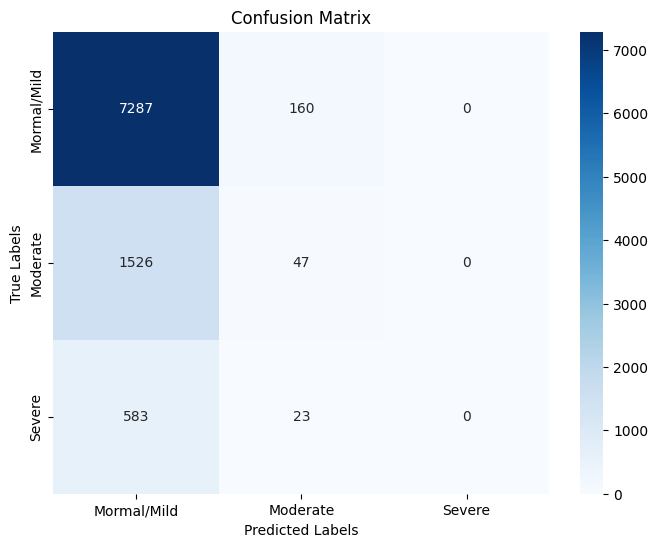

In [ ]:
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Mormal/Mild", "Moderate", "Severe"],
            yticklabels=["Mormal/Mild", "Moderate", "Severe"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()